In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import pickle
from scipy.linalg import hankel
from scipy.stats import norm, zscore
import statsmodels.api as sm
import matplotx

plt.style.use(matplotx.styles.aura["dark"])

In [68]:
def trial_xticks(ax, xlocs, yloc=-0.04):
    xlocs = np.array(xlocs)
    ax.set_xticks(xlocs)
    ax.set_xticklabels([])
    ax.tick_params("x", length=17, width=1, which="major")
    ax.set_xlabel("Time", labelpad=10)

    periods = ["S", "Cue", "Delay", "Arm", "Reward"]
    for i in range(5):
        xloc = xlocs[i] + (xlocs[i + 1] - xlocs[i]) / 2
        ax.text(
            xloc,
            yloc,
            periods[i],
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="top",
            transform=ax.get_xaxis_transform(),
            rotation=0,
        )


def nll(w, X, y):
    lam = np.exp(X @ w)
    # print(lam.shape)
    return -1 * y.T @ np.log(lam) + lam.sum() - 0.5 * w.T @ w


colors = ["tab:red", "tab:blue"]

In [69]:
files = ["test_data_acc_ind_492_0607.pickle", "test_data_dms_ind_492_0603.pickle"]
with open(files[0], "rb") as handle:
    data = pickle.load(handle)
print(data.keys())
n_neurons = len(data["spikes"])
print(f"n_neurons: {n_neurons}")

dict_keys(['nCues_RminusL', 'currMaze', 'laserON', 'trialStart', 'trialEnd', 'keyFrames', 'time', 'cueOnset_L', 'cueOnset_R', 'choice', 'trialType', 'pos', 'spikes', 'timeSqueezedFR'])
n_neurons: 324


In [70]:
time_squeezedFR = np.array(data["timeSqueezedFR"])
mean_fr = time_squeezedFR.mean(axis=(1, 2))
std_fr = time_squeezedFR.std(axis=2).mean(axis=1)
sorted_neurons = np.argsort(mean_fr * std_fr)[::-1]
sorted_neurons[:20]
# time_squeezedFR.shape

array([129, 232,  36, 116, 186, 212, 226,  86, 131,  41,  33, 117, 121,
       120,  70, 237, 149, 271, 123, 216])

In [185]:
# constructing design matrix with all trials

neuron = 32
trial_indices = np.nonzero((data["currMaze"] > 7) * (data["laserON"] == 0))[0]
print(f"number of trials: {trial_indices.size}")
X = []
y = []
filt_len = 30
sp_filt_len = 50
bin_size = 0.05
trial_id = []
bin_positions = []
bin_centers_all = []

for trial_idx in trial_indices:
    keyframes = data["keyFrames"][trial_idx]
    keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
    trial_start = data["trialStart"][trial_idx]
    # trial_end = data["trialEnd"][trial_idx]
    # lcue_times = data["cueOnset_L"][trial_idx]
    # rcue_times = data["cueOnset_R"][trial_idx]
    # trial_start = keyframe_times[0] + data["trialStart"][trial_idx]
    trial_end = keyframe_times[3] + trial_start
    lcue_times = data["cueOnset_L"][
        trial_idx
    ]  # - keyframe_times[0] # remove keyframe subtraction if using all phases of trial
    rcue_times = data["cueOnset_R"][trial_idx]  # - keyframe_times[0]

    trial_length = trial_end - trial_start
    spikes = data["spikes"][neuron]
    spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]

    bins = np.arange(0, trial_length, bin_size)
    bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")
    bin_centers_all.append(bin_centers)

    time = data["time"][trial_idx][:, np.newaxis]
    pos = data["pos"][trial_idx][:, 1]
    bin_centers = bin_centers.reshape(-1, 1)
    dist = time[: pos.size].T - bin_centers
    bin_time_index = np.argmin(np.abs(dist), axis=1)
    binned_pos = pos[bin_time_index]
    bin_positions.append(binned_pos)
    means = np.linspace(0, 275, 10)
    pos_gauss = []
    for mu in means:
        dist = norm(mu, 10)
        pos_gauss.append(dist.pdf(binned_pos))
    pos_gauss = np.array(pos_gauss)

    binned_stimr, _ = np.histogram(rcue_times, bins)
    binned_stiml, _ = np.histogram(lcue_times, bins)
    binned_spikes, _ = np.histogram(spikes - trial_start, bins)
    binned_ev = np.cumsum(binned_stimr) - np.cumsum(binned_stiml)

    padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
    X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
    padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
    X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])
    padded_ev = np.pad(binned_ev, (filt_len - 1, 0), constant_values=(0, 0))
    X_ev = hankel(padded_ev[: -filt_len + 1], padded_ev[-filt_len:])

    padded_spikes = np.pad(binned_spikes[:-1], (sp_filt_len, 0), constant_values=(0, 0))
    X_sp = hankel(padded_spikes[: -sp_filt_len + 1], padded_spikes[-sp_filt_len:])

    trial_type = data["trialType"][trial_idx]
    # X_pos = np.hstack((trial_type * pos_gauss.T, (1 - trial_type) * pos_gauss.T))
    X_pos = pos_gauss.T
    # need to add second pos matrix for choice or evidence
    X.append(np.hstack((X_sr, X_sl, X_pos, np.ones((X_sp.shape[0], 1)))))
    # X.append(np.hstack((X_sr, X_sl, np.ones((X_sp.shape[0], 1)))))

    y.append(binned_spikes[:, np.newaxis])

    trial_id.append(trial_idx * np.ones(X_sr.shape[0]))


# zscore????
X = np.vstack(X)
X[:, : (filt_len * 2)] = zscore(X[:, :60], axis=None)
X[:, (filt_len * 2) : -1] = zscore(X[:, 60:-1], axis=0)
y = np.vstack(y)
trial_id = np.hstack(trial_id)
# ,
print(0, keyframe_times, trial_end - trial_start)
print(X.shape)
print(rcue_times)

number of trials: 210
0 [0.5845199823379517, 9.808429718017578, 125.71129608154297, 126.09971618652344] 126.09971618652344
(39495, 71)
[5.7475414 6.7473097 7.474443  8.926171  9.242626 ]


array([5.380142 , 5.739788 , 6.0282097, 6.460757 , 6.6920214, 7.152971 ,
       7.55806  , 7.6856647], dtype=float32)

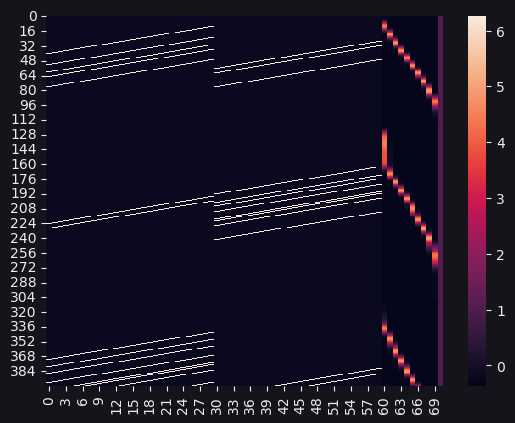

In [186]:
sns.heatmap(X[:400, :])
data["cueOnset_L"][1]

LL: -24021.75690000978
-1.3241767982479946


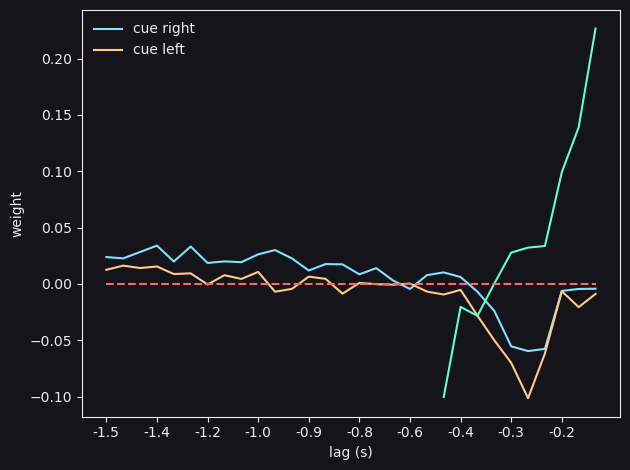

In [187]:
weights = np.zeros(y.shape[0]) * 0.0001
weights[:1000] = 1

glm = sm.GLM(endog=y, exog=X, family=sm.families.Poisson())  # , freq_weights=weights)

# res = glm.fit(max_iter=1000, tol=1e-6, tol_criterion="params")
alpha = 0.1 * np.ones(X.shape[1])
alpha[-1] = 0.001
res = glm.fit_regularized(alpha=alpha, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)
w = res.params
rate = np.exp(X @ w)

LL = y.T @ np.log(rate) - rate.sum()
print(f"LL: {LL[0]}")

fig, ax = plt.subplots()
ax.plot(w[: (2 * filt_len)].reshape(-1, filt_len).T, label=["cue right", "cue left"])
# ax.plot(np.arange(filt_len)[-sp_filt_len:], w[(2*filt_len):-1], label='spikes')
ax.plot(np.arange(20, 30), w[(2 * filt_len) : -1])
# ax.plot(w[:-1].reshape(-1, filt_len).T, label=["cue right", "cue left"])

ax.plot(np.arange(filt_len), np.zeros(filt_len), "--")
ax.legend()
xlabels = np.round(
    -1 * np.arange(bin_size, filt_len * bin_size + bin_size, bin_size)[::-3], 1
)
ax.set_xticks(np.arange(filt_len)[::3], xlabels)
ax.set_xlabel("lag (s)")
ax.set_ylabel("weight")
plt.tight_layout()


print(w[-1])
# res.summary()

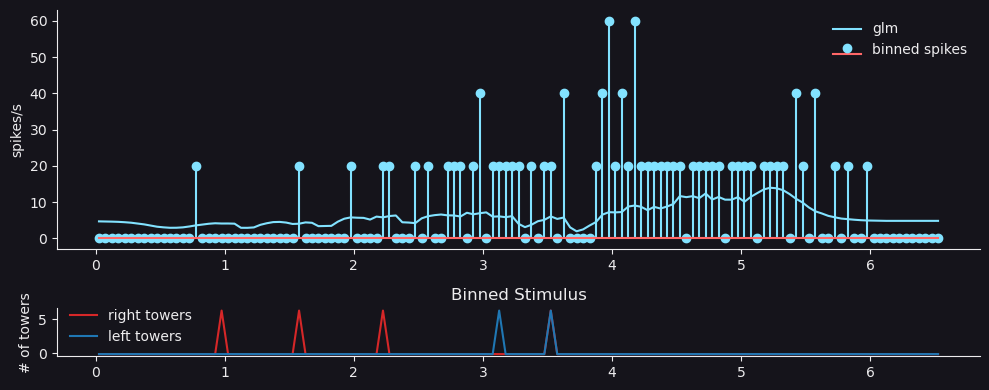

In [188]:
fig, axs = plt.subplots(2, 1, figsize=(10, 4), gridspec_kw={"height_ratios": [5, 1]})

sort_idx = np.argsort(
    data["nCues_RminusL"]
)  # ordered index of (lots of left cues) -> (lots of right cues)
sort_idx = sort_idx[(data["currMaze"][sort_idx] > 7) * (data["laserON"][sort_idx] == 0)]
plot_trial = sort_idx[-100]
X_plot = X[trial_id == plot_trial]
# y_pred = np.exp(X_plot @ theta_init[:, neuron])
y_pred = np.exp(X_plot @ w.T) / bin_size

# y_pred = np.exp(X_plot @ theta_post[:, :, neuron].T)

y_plot = y[trial_id == plot_trial] / bin_size

t = bin_centers_all[np.nonzero(np.unique(trial_id) == plot_trial)[0][0]]
axs[0].stem(t, y_plot, label="binned spikes")
axs[0].plot(t, y_pred, label="glm")
# trial_xticks(axs[0], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
axs[0].set_ylabel("spikes/s")
axs[0].legend()


axs[1].plot(
    t, X[trial_id == plot_trial, filt_len - 1], color=colors[0], label="right towers"
)
axs[1].plot(
    t, X[trial_id == plot_trial, filt_len * 2 - 1], color=colors[1], label="left towers"
)
# trial_xticks(axs[1], xlocs=[0] + keyframe_times + [trial_length], yloc=-0.1)
axs[1].set_ylabel("# of towers")
axs[1].set_title("Binned Stimulus")
axs[1].legend()
plt.tight_layout()
sns.despine()

In [189]:
# bin_centers_all[]

In [190]:
# indices to exclude due to reversal of position
count = 0
turn_idx = []
for i, pos in enumerate(bin_positions):
    grad = np.diff(pos)
    if np.any(grad < -5):
        count += 1
        turn_idx.append(i)
print(count, turn_idx)

5 [198, 199, 203, 208, 209]


In [191]:
bins_before = 10
bins_after = 10

rcues = X[:, filt_len - 1]
lcues = X[:, (2 * filt_len) - 1]

rcues_idx = np.nonzero(rcues > 4)[0]  # CHECK for each file. depends on zscore
lcues_idx = np.nonzero(lcues > 4)[0]

y_pred = np.exp(X @ w.T)

rate_right = []
glm_rate_right = []
for r in rcues_idx:
    rate_right.append(y[(r-bins_before):(r+bins_after)])
    glm_rate_right.append(y_pred[(r-bins_before):(r+bins_after), None])
rate_right, glm_rate_right = np.hstack(rate_right).T, np.hstack(glm_rate_right).T

rate_left = []
glm_rate_left = []
for l in lcues_idx:
    rate_left.append(y[(l-bins_before):(l+bins_after)])
    glm_rate_left.append(y_pred[(l-bins_before):(l+bins_after), None])

rate_left, glm_rate_left = np.hstack(rate_left).T, np.hstack(glm_rate_left).T



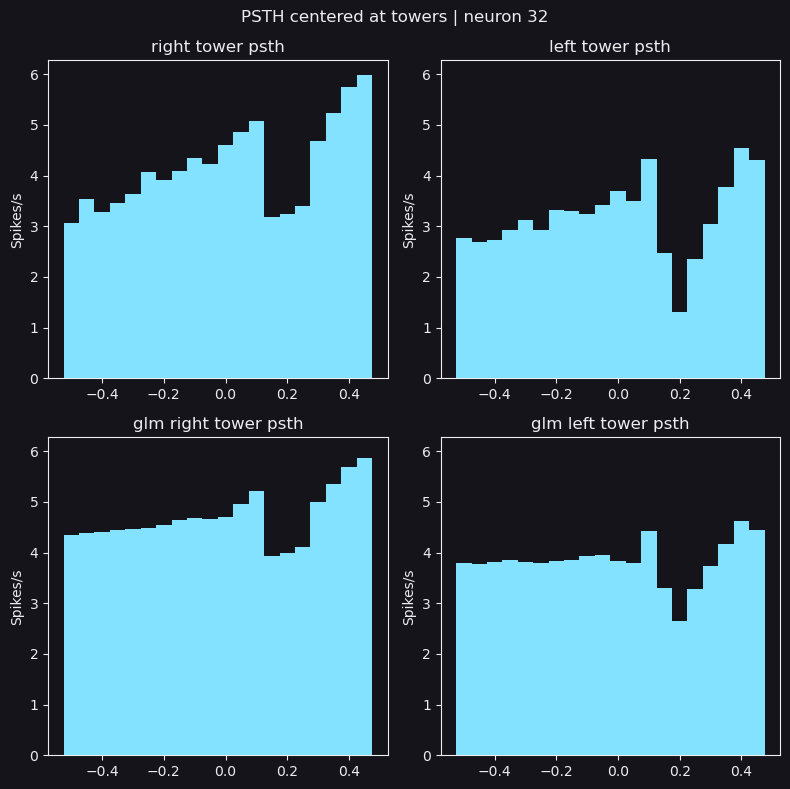

In [192]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.ravel()
max_count = []
for i, r in enumerate([rate_right, rate_left, glm_rate_right, glm_rate_left]):
    rate = r.mean(axis=0)/bin_size
    axs[i].bar(np.arange(-bins_before*bin_size, bins_after*bin_size, bin_size), rate, bin_size)
    max_count.append(rate.max())
    axs[i].set_title('{} tower psth'.format(['right', 'left', 'glm right', 'glm left'][i]))
    axs[i].set_ylabel('Spikes/s')

max_count = np.max(max_count)
max_count *= 1.05
for ax in axs:
    ax.set_ylim([0, max_count])
plt.suptitle(f'PSTH centered at towers | neuron {neuron}')
plt.tight_layout()

In [193]:
bins_before = 10
bins_after = 10

rates = {str(i): [] for i in range(4)}
rates_glm = {str(i): [] for i in range(4)}

bin_edges = np.arange(-14, 15, 7)
n_ev_level, _ = np.histogram(data['nCues_RminusL'][trial_indices], bins=bin_edges)
bin_edges[-1] +=0.001
ev_level = np.digitize(data['nCues_RminusL'][trial_indices], bins=bin_edges) - 1


for i, trial_idx in enumerate(trial_indices):
    keyframes = data["keyFrames"][trial_idx]
    keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
    trial_start = data["trialStart"][trial_idx]
    # trial_end = data["trialEnd"][trial_idx]
    # lcue_times = data["cueOnset_L"][trial_idx] 
    # rcue_times = data["cueOnset_R"][trial_idx]
    # trial_start = keyframe_times[0] + data["trialStart"][trial_idx]
    trial_end = keyframe_times[3] + trial_start
    # arm_enter = trial_start + keyframe_times[2]
    psth_center = keyframe_times[1] 
  
    psth_center_bin = np.argsort(np.abs(psth_center - bin_centers_all[i]))[0]
    # print(bin_centers_all[i].shape, psth_center_bin + bins_after)
    y_trial = y[trial_idx == trial_id]
    y_pred_trial = y_pred[trial_idx == trial_id]
    # print(y_trial.shape, psth_center_bin + bins_after)

    rates[str(ev_level[i])].append(y_trial[(psth_center_bin-bins_before):(psth_center_bin+bins_after)])
    rates_glm[str(ev_level[i])].append(y_pred_trial[(psth_center_bin-bins_before):(psth_center_bin+bins_after)])

np.hstack(rates['1']).shape

(20, 65)

In [194]:
rates['1'][1].shape

(20, 1)

(20, 1)
(20, 1)
(20, 1)
(20, 1)


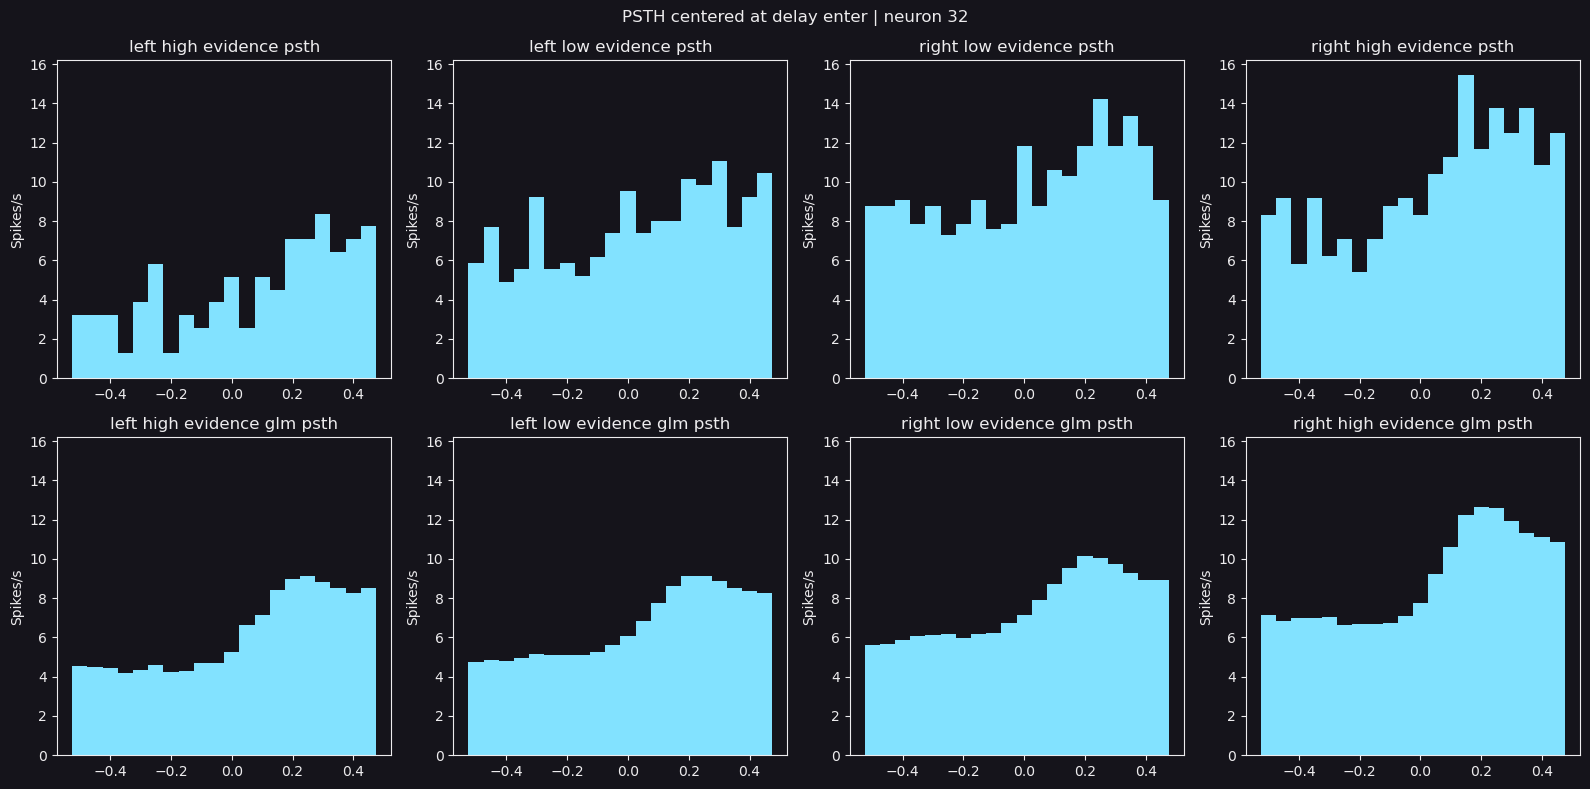

In [195]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
# axs = axs.ravel()
max_count = []
for i, key in enumerate(rates.keys()):
    rate = np.array(rates[key]).mean(axis=0)/bin_size
    print(rate.shape)
    rate_glm = np.array(rates_glm[key]).mean(axis=0)/bin_size
    axs[0, i].bar(np.arange(-bins_before*bin_size, bins_after*bin_size, bin_size), rate.squeeze(), bin_size)
    max_count.append(rate.max())
    axs[0, i].set_title('{} evidence psth'.format(['left high', 'left low', 'right low', 'right high'][i]))
    axs[0, i].set_ylabel('Spikes/s')
    axs[1, i].bar(np.arange(-bins_before*bin_size, bins_after*bin_size, bin_size), rate_glm, bin_size)
    max_count.append(rate_glm.max())
    axs[1, i].set_title('{} evidence glm psth'.format(['left high', 'left low', 'right low', 'right high'][i]))
    axs[1, i].set_ylabel('Spikes/s')

max_count = np.max(max_count)
max_count *= 1.05
for ax in axs.ravel():
    ax.set_ylim([0, max_count])
plt.suptitle(f'PSTH centered at delay enter | neuron {neuron}')
plt.tight_layout()

In [22]:
rates = {str(i): [] for i in range(4)}
rates

{'0': [], '1': [], '2': [], '3': []}